In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats

In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertM

In [109]:
X_string = 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5'
Y_string = 'GDT_score'
DATASET = 'NLP_CLEAN.xlsx'

In [110]:
def del_short_responses(df):
    print(len(df))

    for item in [f'nlp_{i}' for i in range(2, 6)]:
        df = df[df[item].apply(lambda x: len(x) > 10)]
        print(len(df))

    return df

In [111]:
df = pd.read_excel(io=DATASET)
df = df[df['time'] > 300]
df = df[df['label'] != 1]
df = del_short_responses(df)

469
468
460
449
433


In [112]:
df_pilot = pd.read_excel('NLP_PILOT.XLSX')
df_pilot = del_short_responses(df_pilot)

95
95
94
92
91


In [205]:
from typing import Callable, List, Optional, Tuple
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from IPython.display import clear_output
import pandas as pd

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bert_tokenizer, bert_model, max_length):

        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        # self.embedding_func = lambda x: torch.flatten(x[0])
        self.embedding_func = lambda x: torch.mean(x[0], dim=1).squeeze()
        # self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str, progress) -> torch.tensor:
        
        
        print(progress, flush=True)
        
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        
        clear_output(wait=True)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string, f'{text.index(string) + 1}/{len(text)}') for string in text])

In [206]:
bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [207]:
def transform_and_stack(df, arguments=X_string, transformer=bert_transformer):
    tokenized_X_list = []

    for item in arguments:

        item_processed = transformer.transform(list(df[item]))
        tokenized_X_list.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

    tokized_X_tuple = tuple(tokenized_X_list)

    X = np.hstack(tokized_X_tuple)
    y = df[Y_string].values
    return X, y

In [208]:
X_main, y_main = transform_and_stack(df)

nlp_5 added to list


In [209]:
X_pilot, y_pilot = transform_and_stack(df_pilot)

nlp_5 added to list


SVR SECTION

In [210]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kfold = KFold(n_splits=10, shuffle=True, random_state=8)

In [287]:
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge

SVR_function = svm.SVR(kernel='linear', C=0.0255, tol=1e-3)
# SVR_function = svm.LinearSVR(random_state=0, tol=1e-3, max_iter=2000, C=0.0255)
# SVR_function = LinearRegression()
# SVR_function = Ridge(alpha=200)

y_main_true = []
SVR_predictions = []


for train_index, test_index in kfold.split(X_main):

    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]

    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    SVR_prediction = vector_regression.predict(X_test)
    SVR_predictions = np.concatenate((SVR_predictions, SVR_prediction))

    y_main_true = np.concatenate((y_main_true, y_test))

stats.pearsonr(SVR_predictions, y_main_true)

PearsonRResult(statistic=0.4839104771687475, pvalue=8.454151073465908e-27)

In [212]:
def present_results(prediction, true_values):
        
    print(f'MAE: {mean_absolute_error(prediction, true_values)}')
    print(stats.pearsonr(prediction, true_values))
    
    prediction = [item if item >= 4 else 4 for item in prediction]
    prediction = [item if item <= 20 else 20 for item in prediction]

    answers_tuples = [(y, res) for y, res in zip(true_values, prediction)]
    sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

    sorted_results = [x[1] for x in sorted_tuples]

    true_values = [x[0] for x in sorted_tuples]
    prediction = [round(int(item)) for item in sorted_results]

    plt.figure(figsize=(10, 7))
    plt.plot(range(len(prediction)), prediction, 'o', color=[1, 0, 0, 0.7], label="Prediction")
    plt.plot(range(len(true_values)), true_values, 'o', color=[0, 1, 0, 0.5], label='Observable data')
    plt.legend(loc='upper left')
    plt.title('Connected predictions vs real data')
    plt.show()

MAE: 2.434158155741091
PearsonRResult(statistic=0.4839104771687475, pvalue=8.454151073465908e-27)


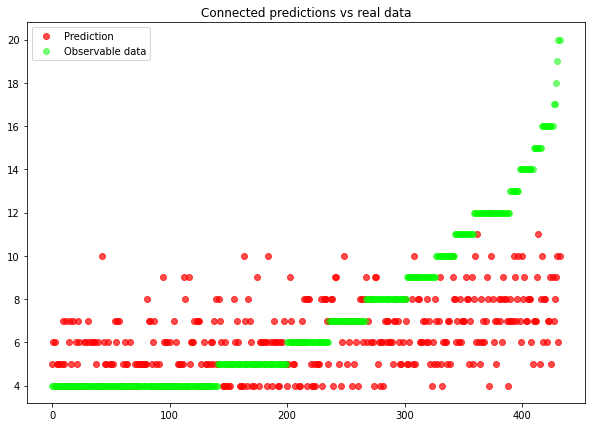

In [213]:
# K FOLD
present_results(SVR_predictions, y_main_true)

MAE: 3.339946654690472
PearsonRResult(statistic=0.26669922529651535, pvalue=0.010605267437896082)


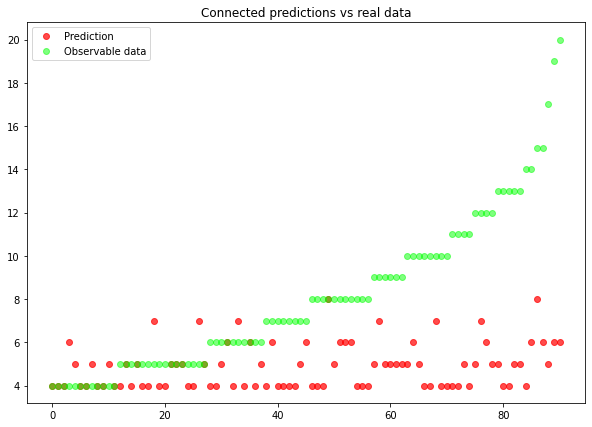

In [265]:
# EVAL DATASET
SVR_pilot_model = SVR_function
SVR_pilot_model.fit(X_main, y_main)
SVR_pilot_predictions = SVR_function.predict(X_pilot)
present_results(SVR_pilot_predictions, y_pilot)

NEURAL NETWORKS SECTION

In [322]:
import tensorflow as tf
import random as python_random

def create_model():
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    keras_model = tf.keras.Sequential([
                        tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(units=1)
                        ])

    keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='mean_absolute_error')
    return keras_model

In [323]:
keras_predictions = []

for train_index, test_index in kfold.split(X_main):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    model = create_model()
    model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=0)
    keras_prediction = model.predict(X_test).flatten()

    keras_predictions = np.concatenate((keras_predictions, keras_prediction))
    print(stats.pearsonr(keras_prediction, y_test))
    
stats.pearsonr(y_main_true, keras_predictions)

2/2 [==============================] - 0s 8ms/step
PearsonRResult(statistic=0.4503576981931009, pvalue=0.0021581326412232)
2/2 [==============================] - 0s 6ms/step
PearsonRResult(statistic=0.5517228913497303, pvalue=0.00010358832951664407)
2/2 [==============================] - 0s 9ms/step
PearsonRResult(statistic=0.5645073202969, pvalue=6.569075960223132e-05)
2/2 [==============================] - 0s 4ms/step
PearsonRResult(statistic=0.28876994841619974, pvalue=0.060378244935782026)
2/2 [==============================] - 0s 5ms/step
PearsonRResult(statistic=0.534785737378112, pvalue=0.00022037632562251652)
2/2 [==============================] - 0s 7ms/step
PearsonRResult(statistic=0.5977247214507925, pvalue=2.313544191314878e-05)
2/2 [==============================] - 0s 5ms/step
PearsonRResult(statistic=0.5798155315446528, pvalue=4.607186908914252e-05)
2/2 [==============================] - 0s 5ms/step
PearsonRResult(statistic=0.4964926590506182, pvalue=0.000708415459113783

PearsonRResult(statistic=0.46428622355597465, pvalue=1.5541989934121373e-24)

MAE: 2.446306862952252
PearsonRResult(statistic=0.46428622355597465, pvalue=1.5541989934121373e-24)


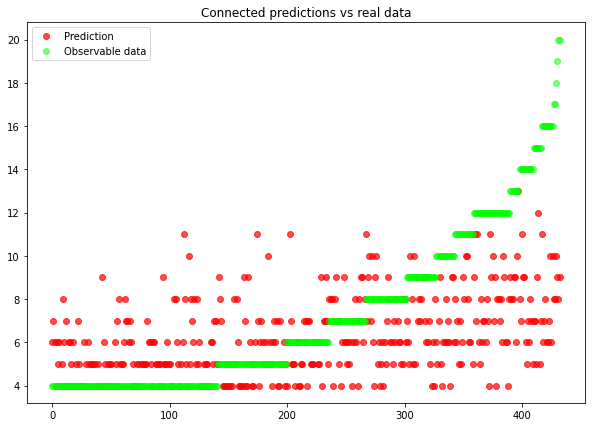

In [324]:
present_results(keras_predictions, y_main_true)

3/3 [==============================] - 0s 6ms/step
MAE: 3.6437295033381534
PearsonRResult(statistic=0.2990484915180105, pvalue=0.003982939842120325)


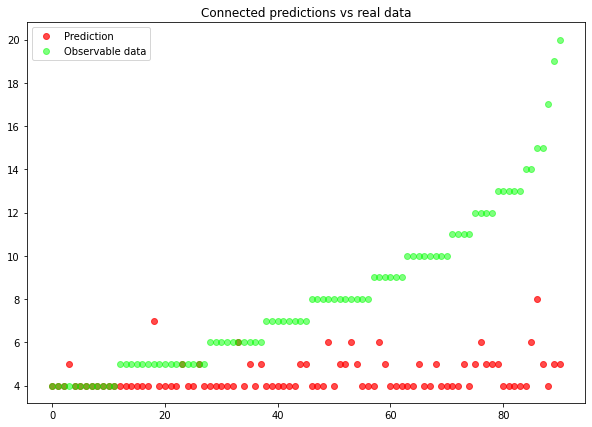

In [325]:
# EVAL DATASET

keras_eval_model = create_model()
keras_eval_model.fit(X_main, y_main, batch_size=64, epochs=200, verbose=0)
keras_pilot_predictions = keras_eval_model.predict(X_pilot).flatten()
present_results(keras_pilot_predictions, y_pilot)


CONNECTING RESULTS

MAE: 2.429939609032746
PearsonRResult(statistic=0.4852518828755726, pvalue=5.846293553256313e-27)


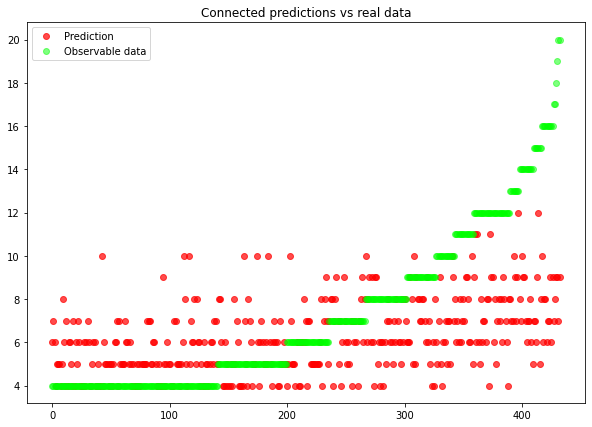

In [326]:
connected_main = [(k + s)/2 for k, s in zip(keras_predictions, SVR_predictions)]
present_results(connected_main, y_main_true)

MAE: 3.47099732546523
PearsonRResult(statistic=0.28778401564047323, pvalue=0.005672955636843394)


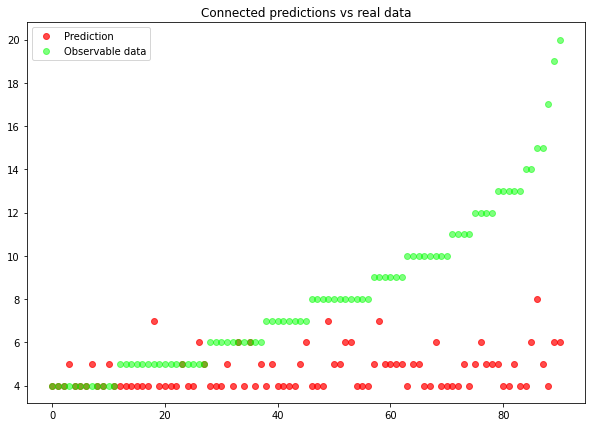

In [327]:
connected_eval = [(k + s)/2 for k, s in zip(keras_pilot_predictions, SVR_pilot_predictions)]
present_results(connected_eval, y_pilot)